In [1]:
# data manipulation and visulization
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
import torchvision
from torchvision import transforms
from torch import nn

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        
    ]
)

test_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
        
    ]
)


In [4]:
from torch.utils.data import DataLoader

trainset = torchvision.datasets.FashionMNIST(root = "./",
                                             train = True,
                                             download = False,
                                             transform= train_transform)
testset = torchvision.datasets.FashionMNIST(root= "./",
                                            train = False, 
                                            download = False,
                                            transform= test_transform)

train_dataloader = DataLoader(dataset= trainset,
                              batch_size= 32,
                              num_workers= 0,
                              shuffle= True)

test_dataloader = DataLoader(dataset= testset,
                             batch_size= 32,
                             num_workers= 0,
                             shuffle= True)

In [5]:
import torch
import torch.nn as nn

class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super(TinyVGG, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )

        self.feature_map_size = hidden_units * 7 * 7  

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self.feature_map_size, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


In [6]:
model = TinyVGG(input_shape = 1,
              hidden_units = 64, 
              output_shape = len(trainset.classes)).to(device)

from torchinfo import summary
print("VGG-16 Summary:","\n",summary(model),"\n")


VGG-16 Summary: 
Layer (type:depth-idx)                   Param #
TinyVGG                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       640
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       36,928
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       36,928
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      31,370
Total params: 142,794
Trainable params: 142,794
Non-trainable params: 0



In [7]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (x,y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        y_pred = model(x)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim =1), dim = 1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred_class)


    # avg train loss and acc
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

def test_step(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module):
    
    model.eval()

    test_loss, test_acc = 0,0

    with torch.inference_mode():
        for batch, (x,y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            test_y_pred = model(x)

            loss = loss_fn(test_y_pred, y)
            test_loss += loss

            test_y_pred_class = torch.argmax(torch.softmax(test_y_pred, dim = 1), dim = 1)
            test_acc += (test_y_pred_class == y).sum().item() / len(test_y_pred_class)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc
    

In [8]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)


In [9]:
from tqdm import tqdm 
from timeit import default_timer as timer 

def train(model:nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 50):
    
    # create an empty results dir
    results = {"train_loss":[],
               "test_loss":[],
               "train_acc":[],
               "test_acc":[],
               "runtime": None,
               "model": None}
    # Early stopping
    early_stopping = EarlyStopping(patience=5, delta=0.01)
    # loop for training an testing
    start_time = timer()
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer)

        test_loss, test_acc = test_step(model = model,
                                        dataloader = test_dataloader,
                                        loss_fn = loss_fn)

        
        print(
            f"epochs: {epoch+1} | train_loss: {train_loss} | train_acc: {train_acc} | test_loss: {test_loss} | test_acc: {test_acc}"
            )
        
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)
        
        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    end_time = timer()

    results["runtime"] = f"{end_time - start_time:.3f} seconds"
    
    # load the best model for this optimizer 
    results["model"] = early_stopping.load_best_model(model)
    return results

In [10]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

num_epochs = 50

loss_fn = nn.CrossEntropyLoss()
optimizer = {
    "SGD": lambda params: torch.optim.SGD(params, lr = 0.001),
    "RMSprop": lambda params: torch.optim.RMSprop(params, lr = 0.001),
    "Adam": lambda params: torch.optim.Adam(params, lr = 0.001),
    "Adagrad": lambda params: torch.optim.Adagrad(params, lr = 0.001),
    "AdaDelta": lambda params: torch.optim.Adadelta(params, lr = 0.001)
}

opt_results = {}
for opt_name, opt_func in tqdm(optimizer.items(), desc = "optimizer count:"):
    print(f"Training with {opt_name}...")

    model = TinyVGG(input_shape = 1,
              hidden_units = 64, 
              output_shape = len(trainset.classes)).to(device)
    model_reults = train(model = model,
                        train_dataloader= train_dataloader,
                        test_dataloader= test_dataloader,
                        loss_fn= loss_fn,
                        optimizer= opt_func(model.parameters()),
                        epochs= num_epochs)
    opt_results[opt_name] = model_reults

optimizer count::   0%|          | 0/5 [00:00<?, ?it/s]

Training with SGD...


epochs: 1 | train_loss: 1.6921770830790202 | train_acc: 0.3977 | test_loss: 0.8707225322723389 | test_acc: 0.6951876996805112


epochs: 2 | train_loss: 0.7739626243114471 | train_acc: 0.7265333333333334 | test_loss: 0.7232730388641357 | test_acc: 0.740814696485623


epochs: 3 | train_loss: 0.6810603660106659 | train_acc: 0.7576333333333334 | test_loss: 0.6885539889335632 | test_acc: 0.7492012779552716


epochs: 4 | train_loss: 0.6153294547398885 | train_acc: 0.7823333333333333 | test_loss: 0.5978519320487976 | test_acc: 0.7926317891373802


epochs: 5 | train_loss: 0.5663978200833003 | train_acc: 0.7996166666666666 | test_loss: 0.5537639856338501 | test_acc: 0.8055111821086262


epochs: 6 | train_loss: 0.5294796648581823 | train_acc: 0.8127 | test_loss: 0.5248970985412598 | test_acc: 0.8167931309904153


epochs: 7 | train_loss: 0.5032887727340063 | train_acc: 0.8220666666666666 | test_loss: 0.5319952964782715 | test_acc: 0.8158945686900958


epochs: 8 | train_loss: 0.4810077961762746 | train_acc: 0.8296333333333333 | test_loss: 0.4913523495197296 | test_acc: 0.8297723642172524


epochs: 9 | train_loss: 0.4634931069612503 | train_acc: 0.8356333333333333 | test_loss: 0.48318859934806824 | test_acc: 0.8260782747603834


epochs: 10 | train_loss: 0.447788104112943 | train_acc: 0.8416833333333333 | test_loss: 0.46622633934020996 | test_acc: 0.8299720447284346


epochs: 11 | train_loss: 0.43450991504589714 | train_acc: 0.8456833333333333 | test_loss: 0.4441271722316742 | test_acc: 0.8428514376996805


epochs: 12 | train_loss: 0.42311601776281993 | train_acc: 0.84925 | test_loss: 0.45950186252593994 | test_acc: 0.8300718849840255


epochs: 13 | train_loss: 0.41283269466161726 | train_acc: 0.8528166666666667 | test_loss: 0.4334317445755005 | test_acc: 0.8471445686900958


epochs: 14 | train_loss: 0.4030968250791232 | train_acc: 0.8564 | test_loss: 0.4298892319202423 | test_acc: 0.8481429712460063


epochs: 15 | train_loss: 0.3964749925851822 | train_acc: 0.85885 | test_loss: 0.41362765431404114 | test_acc: 0.8504392971246006


epochs: 16 | train_loss: 0.38766448202927906 | train_acc: 0.8606 | test_loss: 0.424650639295578 | test_acc: 0.8489416932907349


epochs: 17 | train_loss: 0.38097310504118603 | train_acc: 0.8631833333333333 | test_loss: 0.39767152070999146 | test_acc: 0.8607228434504792


epochs: 18 | train_loss: 0.37648226737181345 | train_acc: 0.8659333333333333 | test_loss: 0.3945236802101135 | test_acc: 0.8594249201277955


epochs: 19 | train_loss: 0.3698905672987302 | train_acc: 0.8686833333333334 | test_loss: 0.3914826214313507 | test_acc: 0.8550319488817891


epochs: 20 | train_loss: 0.3638361403385798 | train_acc: 0.8694666666666667 | test_loss: 0.397196888923645 | test_acc: 0.8540335463258786


epochs: 21 | train_loss: 0.3589227599600951 | train_acc: 0.8706833333333334 | test_loss: 0.39600953459739685 | test_acc: 0.858526357827476


optimizer count::  20%|██        | 1/5 [09:25<37:40, 565.02s/it]

epochs: 22 | train_loss: 0.35515675243337946 | train_acc: 0.8721333333333333 | test_loss: 0.3910624086856842 | test_acc: 0.860323482428115
Early stopping
Training with RMSprop...


epochs: 1 | train_loss: 0.45260767876505853 | train_acc: 0.842 | test_loss: 0.32837653160095215 | test_acc: 0.8803913738019169


epochs: 2 | train_loss: 0.26725040696760016 | train_acc: 0.9030666666666667 | test_loss: 0.26510703563690186 | test_acc: 0.9074480830670927


epochs: 3 | train_loss: 0.22866623226205507 | train_acc: 0.9186666666666666 | test_loss: 0.24370306730270386 | test_acc: 0.9131389776357828


epochs: 4 | train_loss: 0.20529744680921236 | train_acc: 0.9254833333333333 | test_loss: 0.25359150767326355 | test_acc: 0.9096445686900958


epochs: 5 | train_loss: 0.18916857822587094 | train_acc: 0.9316666666666666 | test_loss: 0.23954029381275177 | test_acc: 0.9134384984025559


epochs: 6 | train_loss: 0.17566169933329026 | train_acc: 0.9370166666666667 | test_loss: 0.2700098156929016 | test_acc: 0.9104432907348243


epochs: 7 | train_loss: 0.16622041684985162 | train_acc: 0.9401666666666667 | test_loss: 0.23324111104011536 | test_acc: 0.9206269968051118


epochs: 8 | train_loss: 0.15522342399135233 | train_acc: 0.94485 | test_loss: 0.23986905813217163 | test_acc: 0.9197284345047924


epochs: 9 | train_loss: 0.1473619904100895 | train_acc: 0.9463 | test_loss: 0.23193205893039703 | test_acc: 0.9241214057507987


epochs: 10 | train_loss: 0.1413441452520589 | train_acc: 0.9497166666666667 | test_loss: 0.22988979518413544 | test_acc: 0.920826677316294


epochs: 11 | train_loss: 0.13159964081694683 | train_acc: 0.9524833333333333 | test_loss: 0.2419624626636505 | test_acc: 0.920926517571885


optimizer count::  40%|████      | 2/5 [14:30<20:36, 412.15s/it]

epochs: 12 | train_loss: 0.12602656158010164 | train_acc: 0.9540333333333333 | test_loss: 0.2474968433380127 | test_acc: 0.924520766773163
Early stopping
Training with Adam...


epochs: 1 | train_loss: 0.40856476784944534 | train_acc: 0.8544666666666667 | test_loss: 0.31420180201530457 | test_acc: 0.889576677316294


epochs: 2 | train_loss: 0.2619036990215381 | train_acc: 0.9063833333333333 | test_loss: 0.2612602114677429 | test_acc: 0.9054512779552716


epochs: 3 | train_loss: 0.22180523952643078 | train_acc: 0.92025 | test_loss: 0.23546406626701355 | test_acc: 0.9150359424920128


epochs: 4 | train_loss: 0.20015968756129343 | train_acc: 0.9278 | test_loss: 0.2534961402416229 | test_acc: 0.9084464856230032


epochs: 5 | train_loss: 0.18469855129420756 | train_acc: 0.9324666666666667 | test_loss: 0.22202156484127045 | test_acc: 0.9221246006389776


epochs: 6 | train_loss: 0.1703659071110189 | train_acc: 0.9389333333333333 | test_loss: 0.21841779351234436 | test_acc: 0.9230231629392971


epochs: 7 | train_loss: 0.15961702856495977 | train_acc: 0.9414333333333333 | test_loss: 0.23940078914165497 | test_acc: 0.9212260383386581


epochs: 8 | train_loss: 0.14916874850541353 | train_acc: 0.9452833333333334 | test_loss: 0.2343120276927948 | test_acc: 0.9224241214057508


epochs: 9 | train_loss: 0.13901749202844998 | train_acc: 0.9495 | test_loss: 0.24190467596054077 | test_acc: 0.9178314696485623


optimizer count::  60%|██████    | 3/5 [18:45<11:21, 340.56s/it]

epochs: 10 | train_loss: 0.13373989878706635 | train_acc: 0.9510333333333333 | test_loss: 0.24840869009494781 | test_acc: 0.9207268370607029
Early stopping
Training with Adagrad...


epochs: 1 | train_loss: 0.5730221235990525 | train_acc: 0.7979333333333334 | test_loss: 0.4848022758960724 | test_acc: 0.8303714057507987


epochs: 2 | train_loss: 0.44196601372162503 | train_acc: 0.8446833333333333 | test_loss: 0.44509047269821167 | test_acc: 0.8416533546325878


epochs: 3 | train_loss: 0.4122348959048589 | train_acc: 0.8543833333333334 | test_loss: 0.4254654347896576 | test_acc: 0.8481429712460063


epochs: 4 | train_loss: 0.39313659709294635 | train_acc: 0.86095 | test_loss: 0.40479978919029236 | test_acc: 0.8518370607028753


epochs: 5 | train_loss: 0.3802221839348475 | train_acc: 0.8659 | test_loss: 0.39562535285949707 | test_acc: 0.8587260383386581


epochs: 6 | train_loss: 0.3704853631456693 | train_acc: 0.8695 | test_loss: 0.3915848731994629 | test_acc: 0.860423322683706


epochs: 7 | train_loss: 0.36229517923792204 | train_acc: 0.8720333333333333 | test_loss: 0.38174742460250854 | test_acc: 0.8630191693290735


epochs: 8 | train_loss: 0.3547591924766699 | train_acc: 0.8745833333333334 | test_loss: 0.3745751678943634 | test_acc: 0.8671126198083067


epochs: 9 | train_loss: 0.3501179478128751 | train_acc: 0.8766166666666667 | test_loss: 0.37154537439346313 | test_acc: 0.8673123003194888


epochs: 10 | train_loss: 0.3431106348077456 | train_acc: 0.8789166666666667 | test_loss: 0.36665457487106323 | test_acc: 0.8689097444089456


epochs: 11 | train_loss: 0.33815757435361543 | train_acc: 0.8796666666666667 | test_loss: 0.3666289150714874 | test_acc: 0.867611821086262


epochs: 12 | train_loss: 0.33503891725540164 | train_acc: 0.8816833333333334 | test_loss: 0.361766517162323 | test_acc: 0.8728035143769968


epochs: 13 | train_loss: 0.3311948223888874 | train_acc: 0.8837 | test_loss: 0.3549046218395233 | test_acc: 0.8693091054313099


epochs: 14 | train_loss: 0.3268034429828326 | train_acc: 0.88475 | test_loss: 0.3516007661819458 | test_acc: 0.8741014376996805


epochs: 15 | train_loss: 0.3237216753363609 | train_acc: 0.8858833333333334 | test_loss: 0.3481707274913788 | test_acc: 0.8773961661341853


epochs: 16 | train_loss: 0.32022054107983905 | train_acc: 0.8865666666666666 | test_loss: 0.3454974889755249 | test_acc: 0.8763977635782748


epochs: 17 | train_loss: 0.31760011476476985 | train_acc: 0.8883166666666666 | test_loss: 0.3460116684436798 | test_acc: 0.8740015974440895


epochs: 18 | train_loss: 0.31498787498672803 | train_acc: 0.8882166666666667 | test_loss: 0.342387855052948 | test_acc: 0.8789936102236422


epochs: 19 | train_loss: 0.31262426787217457 | train_acc: 0.8894333333333333 | test_loss: 0.33944812417030334 | test_acc: 0.8773961661341853


epochs: 20 | train_loss: 0.3093763376613458 | train_acc: 0.8899166666666667 | test_loss: 0.3355638384819031 | test_acc: 0.8816892971246006


epochs: 21 | train_loss: 0.30731459600329397 | train_acc: 0.8914833333333333 | test_loss: 0.3381119668483734 | test_acc: 0.8822883386581469


epochs: 22 | train_loss: 0.3055804907361666 | train_acc: 0.8918 | test_loss: 0.3379596173763275 | test_acc: 0.8781948881789138


epochs: 23 | train_loss: 0.30354309725562734 | train_acc: 0.8928666666666667 | test_loss: 0.3315948247909546 | test_acc: 0.8797923322683706


optimizer count::  80%|████████  | 4/5 [28:58<07:28, 448.04s/it]

epochs: 24 | train_loss: 0.30191181417902313 | train_acc: 0.8931833333333333 | test_loss: 0.3335403800010681 | test_acc: 0.8792931309904153
Early stopping
Training with AdaDelta...


epochs: 1 | train_loss: 2.2689557164510092 | train_acc: 0.20343333333333333 | test_loss: 2.173870325088501 | test_acc: 0.3367611821086262


epochs: 2 | train_loss: 1.649642549832662 | train_acc: 0.5356 | test_loss: 1.1483509540557861 | test_acc: 0.6534544728434505


epochs: 3 | train_loss: 0.984794481865565 | train_acc: 0.6820666666666667 | test_loss: 0.8970297574996948 | test_acc: 0.6944888178913738


epochs: 4 | train_loss: 0.844073121436437 | train_acc: 0.7108166666666667 | test_loss: 0.823498010635376 | test_acc: 0.7123602236421726


epochs: 5 | train_loss: 0.7856149783293406 | train_acc: 0.72695 | test_loss: 0.7827552556991577 | test_acc: 0.726138178913738


epochs: 6 | train_loss: 0.7492019303003947 | train_acc: 0.7389333333333333 | test_loss: 0.7534919381141663 | test_acc: 0.739117412140575


epochs: 7 | train_loss: 0.7204890836397807 | train_acc: 0.7508666666666667 | test_loss: 0.7306184768676758 | test_acc: 0.744508785942492


epochs: 8 | train_loss: 0.6965606857776642 | train_acc: 0.7570833333333333 | test_loss: 0.7078496813774109 | test_acc: 0.7541932907348243


epochs: 9 | train_loss: 0.6757268386522929 | train_acc: 0.76615 | test_loss: 0.689206063747406 | test_acc: 0.7571884984025559


epochs: 10 | train_loss: 0.6567401195049286 | train_acc: 0.7717 | test_loss: 0.6700764298439026 | test_acc: 0.7644768370607029


epochs: 11 | train_loss: 0.6394315606276194 | train_acc: 0.7776666666666666 | test_loss: 0.6520110964775085 | test_acc: 0.770367412140575


epochs: 12 | train_loss: 0.6243920693556467 | train_acc: 0.7827333333333333 | test_loss: 0.6380104422569275 | test_acc: 0.7728634185303515


epochs: 13 | train_loss: 0.6099381083965302 | train_acc: 0.7877166666666666 | test_loss: 0.6213773488998413 | test_acc: 0.7810503194888179


epochs: 14 | train_loss: 0.5961560094912847 | train_acc: 0.79245 | test_loss: 0.6111435294151306 | test_acc: 0.7846445686900958


epochs: 15 | train_loss: 0.5833641708930334 | train_acc: 0.7969166666666667 | test_loss: 0.5990966558456421 | test_acc: 0.7888378594249201


epochs: 16 | train_loss: 0.5710781718413035 | train_acc: 0.8010833333333334 | test_loss: 0.5907489657402039 | test_acc: 0.7917332268370607


epochs: 17 | train_loss: 0.560269776336352 | train_acc: 0.8048166666666666 | test_loss: 0.5756740570068359 | test_acc: 0.7985223642172524


epochs: 18 | train_loss: 0.551128954410553 | train_acc: 0.8076333333333333 | test_loss: 0.5655861496925354 | test_acc: 0.8024161341853036


epochs: 19 | train_loss: 0.5414131530284881 | train_acc: 0.8114 | test_loss: 0.5569822788238525 | test_acc: 0.8043130990415336


epochs: 20 | train_loss: 0.5326885767300924 | train_acc: 0.8158 | test_loss: 0.5514262914657593 | test_acc: 0.8074081469648562


epochs: 21 | train_loss: 0.5256697650114696 | train_acc: 0.8178 | test_loss: 0.5435912609100342 | test_acc: 0.8099041533546326


epochs: 22 | train_loss: 0.5175065495808919 | train_acc: 0.8196 | test_loss: 0.5373568534851074 | test_acc: 0.8102036741214057


epochs: 23 | train_loss: 0.5114569816629092 | train_acc: 0.8229166666666666 | test_loss: 0.5292429327964783 | test_acc: 0.8148961661341853


epochs: 24 | train_loss: 0.5052953571399053 | train_acc: 0.8247833333333333 | test_loss: 0.524497926235199 | test_acc: 0.8166932907348243


epochs: 25 | train_loss: 0.4997851704041163 | train_acc: 0.8265666666666667 | test_loss: 0.5204735994338989 | test_acc: 0.8189896166134185


epochs: 26 | train_loss: 0.4945415603955587 | train_acc: 0.8283833333333334 | test_loss: 0.513999879360199 | test_acc: 0.8197883386581469


epochs: 27 | train_loss: 0.48925696946779884 | train_acc: 0.8304 | test_loss: 0.5072141885757446 | test_acc: 0.8218849840255591


epochs: 28 | train_loss: 0.48393954380750653 | train_acc: 0.83215 | test_loss: 0.5033023953437805 | test_acc: 0.8228833865814696


epochs: 29 | train_loss: 0.4791836842974027 | train_acc: 0.8339 | test_loss: 0.5020359754562378 | test_acc: 0.8199880191693291


epochs: 30 | train_loss: 0.47569466401735944 | train_acc: 0.8347166666666667 | test_loss: 0.4952661693096161 | test_acc: 0.828973642172524


epochs: 31 | train_loss: 0.4715890929102898 | train_acc: 0.8374333333333334 | test_loss: 0.4922555983066559 | test_acc: 0.827076677316294


epochs: 32 | train_loss: 0.46754598592917124 | train_acc: 0.8379833333333333 | test_loss: 0.4871613681316376 | test_acc: 0.8304712460063898


epochs: 33 | train_loss: 0.4642092815796534 | train_acc: 0.8379 | test_loss: 0.48474204540252686 | test_acc: 0.8298722044728435


epochs: 34 | train_loss: 0.4599478672623634 | train_acc: 0.8410833333333333 | test_loss: 0.4816018342971802 | test_acc: 0.8311701277955271


epochs: 35 | train_loss: 0.45674232599337894 | train_acc: 0.8416166666666667 | test_loss: 0.47960400581359863 | test_acc: 0.8316693290734825


epochs: 36 | train_loss: 0.4531208554983139 | train_acc: 0.84295 | test_loss: 0.4728136956691742 | test_acc: 0.8334664536741214


epochs: 37 | train_loss: 0.4502144724210103 | train_acc: 0.84415 | test_loss: 0.47215503454208374 | test_acc: 0.8351637380191693


epochs: 38 | train_loss: 0.4473126930554708 | train_acc: 0.8449333333333333 | test_loss: 0.4682479202747345 | test_acc: 0.8370607028753994


epochs: 39 | train_loss: 0.4447644064863523 | train_acc: 0.8454166666666667 | test_loss: 0.4663752615451813 | test_acc: 0.8383586261980831


epochs: 40 | train_loss: 0.44177364207108816 | train_acc: 0.8474333333333334 | test_loss: 0.4633066952228546 | test_acc: 0.8362619808306709


epochs: 41 | train_loss: 0.43934630812009173 | train_acc: 0.8481833333333333 | test_loss: 0.4609009325504303 | test_acc: 0.8377595846645367


epochs: 42 | train_loss: 0.4364642297188441 | train_acc: 0.8493 | test_loss: 0.45732179284095764 | test_acc: 0.8401557507987221


epochs: 43 | train_loss: 0.4342744988640149 | train_acc: 0.84875 | test_loss: 0.45731014013290405 | test_acc: 0.8408546325878594


epochs: 44 | train_loss: 0.4315052543203036 | train_acc: 0.8498166666666667 | test_loss: 0.4543035328388214 | test_acc: 0.84185303514377


epochs: 45 | train_loss: 0.42924025150140127 | train_acc: 0.8516166666666667 | test_loss: 0.45123061537742615 | test_acc: 0.8416533546325878


epochs: 46 | train_loss: 0.4275048258105914 | train_acc: 0.8517666666666667 | test_loss: 0.4493304193019867 | test_acc: 0.8408546325878594


epochs: 47 | train_loss: 0.4255424580891927 | train_acc: 0.8516166666666667 | test_loss: 0.44630447030067444 | test_acc: 0.8421525559105432


epochs: 48 | train_loss: 0.4233235751628876 | train_acc: 0.8524833333333334 | test_loss: 0.4440195560455322 | test_acc: 0.8481429712460063


epochs: 49 | train_loss: 0.42083557956616086 | train_acc: 0.85425 | test_loss: 0.4429782032966614 | test_acc: 0.8460463258785943


optimizer count:: 100%|██████████| 5/5 [50:13<00:00, 602.73s/it]

epochs: 50 | train_loss: 0.4190667140007019 | train_acc: 0.8552166666666666 | test_loss: 0.4432852268218994 | test_acc: 0.84375
total training time: 3013.679 seconds


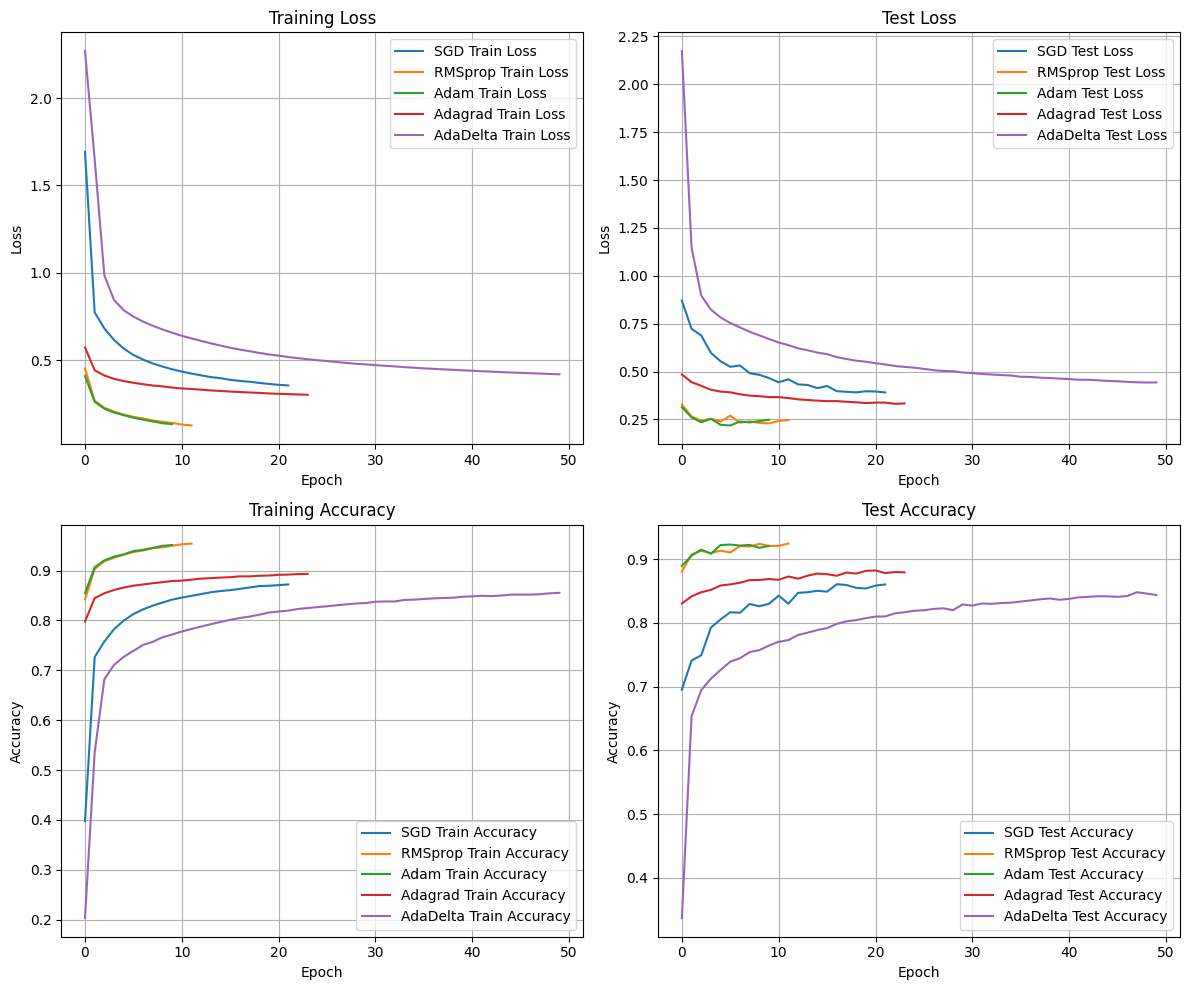

In [ ]:
plt.figure(figsize=(12, 10))

# Plot training loss
plt.subplot(2, 2, 1)
for opt_name, result in opt_results.items():
    plt.plot(result['train_loss'], label=f"{opt_name} Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot test loss
plt.subplot(2, 2, 2)
for opt_name, result in opt_results.items():
    plt.plot(result["test_loss"], label=f"{opt_name} Test Loss")
plt.title("Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot training accuracy
plt.subplot(2, 2, 3)
for opt_name, result in opt_results.items():
    plt.plot(result['train_acc'], label=f"{opt_name} Train Accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot test accuracy
plt.subplot(2, 2, 4)
for opt_name, result in opt_results.items():
    plt.plot(result['test_acc'], label=f"{opt_name} Test Accuracy")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


for opt_name, result in opt_results.items():
    print(f"Runtime of {opt_name}: {result["runtime"]}")

In [31]:
""" 
* Adam and RMSProp gives us a good results 
"""

' \n* Adam and RMSProp gives us a good results \n'

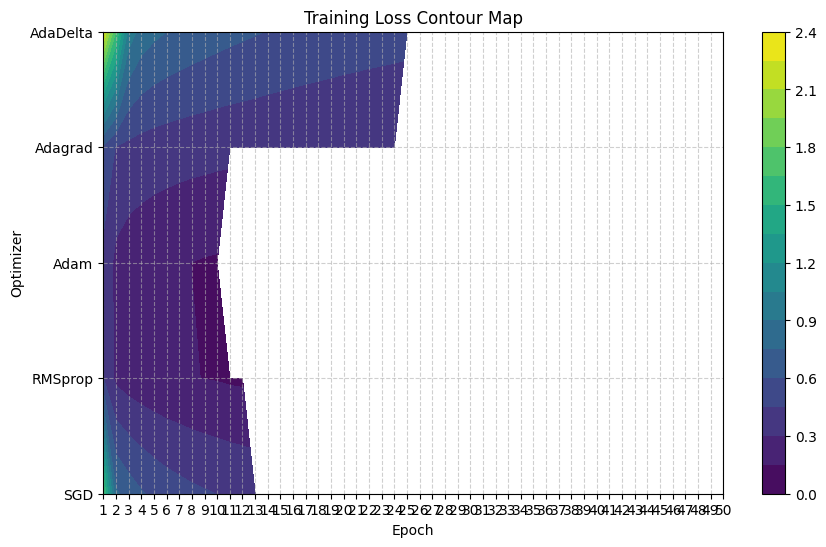

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Prepare data for contour plot
optimizers = list(opt_results.keys())
num_epochs = max(len(opt_results[opt_name]['train_loss']) for opt_name in optimizers)
epochs = list(range(1, num_epochs + 1))

# Pad losses to ensure they have the same length
padded_losses = []
for opt_name in optimizers:
    losses = opt_results[opt_name]['train_loss']
    padded_losses.append(losses + [None] * (num_epochs - len(losses)))

# Convert to a 2D array, using `nan` for missing values
loss_matrix = np.array(padded_losses, dtype=float)
loss_matrix[np.isnan(loss_matrix)] = np.nan  # Replace None with nan for plotting

# Create a contour plot
plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(epochs, range(len(optimizers)))  # Grid for epochs and optimizers
Z = loss_matrix

# Plot the contour map
contour = plt.contourf(X, Y, Z, cmap='viridis', levels=20)
plt.colorbar(contour)

# Add labels
plt.title("Training Loss Contour Map")
plt.xlabel("Epoch")
plt.ylabel("Optimizer")
plt.yticks(range(len(optimizers)), optimizers)
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


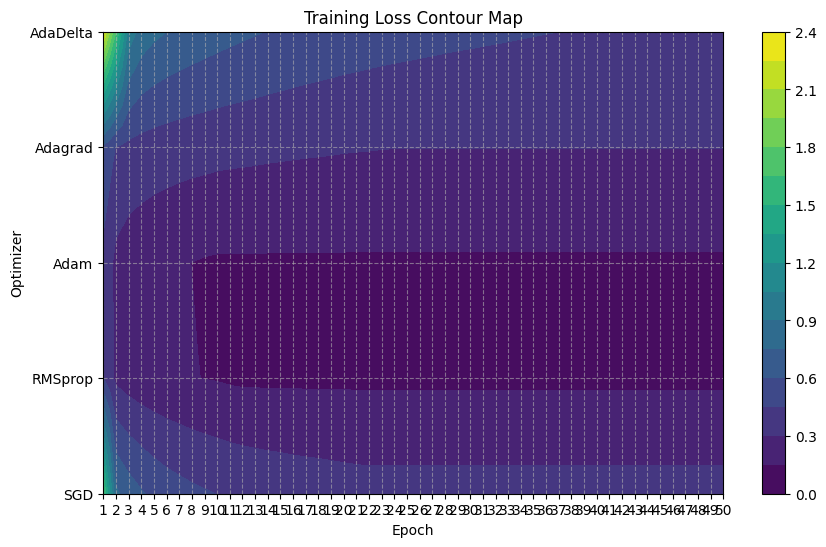

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data for contour plot
optimizers = list(opt_results.keys())
num_epochs = max(len(opt_results[opt_name]['train_loss']) for opt_name in optimizers)
epochs = np.linspace(1, num_epochs, 100)  # Create a finer grid for epochs

# Pad losses to ensure they have the same length and interpolate
padded_losses = []
for opt_name in optimizers:
    losses = opt_results[opt_name]['train_loss']
    # Interpolating each optimizer's losses to match the finer grid
    interpolated_losses = np.interp(epochs, range(1, len(losses) + 1), losses)
    padded_losses.append(interpolated_losses)

# Convert to a 2D array
loss_matrix = np.array(padded_losses)

# Create a grid for plotting
X, Y = np.meshgrid(epochs, np.arange(len(optimizers)))

# Plot the contour map
plt.figure(figsize=(10, 6))
contour = plt.contourf(X, Y, loss_matrix, cmap='viridis', levels=20)
plt.colorbar(contour)

# Add labels
plt.title("Training Loss Contour Map")
plt.xlabel("Epoch")
plt.ylabel("Optimizer")
plt.yticks(np.arange(len(optimizers)), optimizers)
plt.xticks(np.linspace(1, num_epochs, num_epochs))
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()
